In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


In [4]:
import pandas as pd 
import numpy as np
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from csv import reader
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
from scipy.sparse import csr_matrix
import scipy as sp
# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from sklearn.cluster import KMeans
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD, BaselineOnly, CoClustering, NMF
import heapq
# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

In [5]:
sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

In [6]:
sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [7]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
train.shape

(10000038, 4)

In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
movies.shape

(62423, 3)

In [11]:
movies.describe

<bound method NDFrame.describe of        movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  

In [12]:
dataset=pd.merge(train,movies,on='movieId')

In [13]:
dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [14]:
import datetime
from datetime import datetime,date
dataset['datetime']=pd.to_datetime(dataset['timestamp'])

In [15]:
dataset.shape

(10000038, 7)

In [16]:
dataset.nunique()

userId        162541
movieId        48213
rating            10
timestamp    8795101
title          48151
genres          1558
datetime     8795101
dtype: int64

EDA

In [17]:
train1 = train.copy()
train1.drop('timestamp', axis = 1, inplace = True)

In [18]:
ratings_per_user = train1.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)

In [19]:
ratings_per_user.head(10)

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


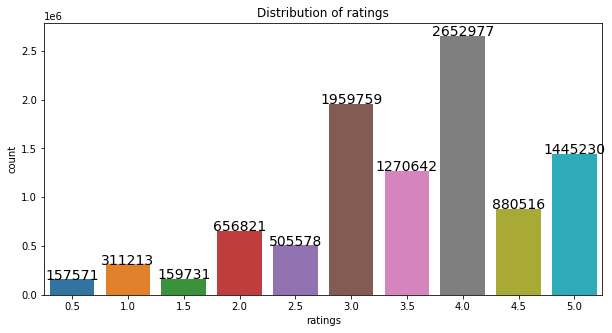

In [20]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=dataset, x='rating')
labels = (train['rating'].value_counts().sort_index())
plt.title('Distribution of ratings')
plt.xlabel('ratings')

for i,v in enumerate(labels):
    ax.text(i, v+100, str(v), horizontalalignment='center', size=14, color='black')
plt.show()

In [21]:
dataset=dataset.groupby('title')['rating'].mean()
dataset

title
"BLOW THE NIGHT!" Let's Spend the Night Together (1983)    3.000000
"Great Performances" Cats (1998)                           2.753731
#1 Cheerleader Camp (2010)                                 1.900000
#Female Pleasure (2018)                                    4.000000
#FollowMe (2019)                                           2.400000
                                                             ...   
به نام پدر                                                 3.250000
…And the Fifth Horseman Is Fear (1965)                     3.000000
チェブラーシカ (2010)                                             2.000000
貞子3D (2012)                                                2.562500
줄탁동시 (2012)                                                3.000000
Name: rating, Length: 48151, dtype: float64

In [22]:
sorted_train_wise_movies=dataset.sort_values(ascending=False)
sorted_train_wise_movies

title
Which Way Home (2009)                 5.0
Kaakha Kaakha (2003)                  5.0
Not Quite Human II (1989)             5.0
Selling Isobel (2018)                 5.0
Sehar (2005)                          5.0
                                     ... 
Down and Out with the Dolls (2001)    0.5
The Informer (2019)                   0.5
Dough and Dynamite (1914)             0.5
Ideal Husband, An (1947)              0.5
Dopo quella notte (2010)              0.5
Name: rating, Length: 48151, dtype: float64

In [23]:
# Load reader and data in surprise friendly format
reader = Reader(rating_scale=(0.5, 5))
train2 = Dataset.load_from_df(train1[['userId', 'movieId', 'rating']], reader)

In [24]:
# Baseline Only model

algo_b = BaselineOnly()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_b.fit(trainset)
predictions_b = algo_b.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_b, verbose=True)

Estimating biases using als...
RMSE: 0.8652


0.865238940916113

In [25]:
# SVD model

algo_svd = SVD()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_svd, verbose=True)

RMSE: 0.8263


0.8263111353431118

In [26]:
mydict = {f'SVD': 0.8263,
          f'Baseline Only': 0.8652
         }

i = pd.DataFrame(mydict.items(), columns=['Model', 'RSME'])
i

,Model,RSME
0,SVD,0.8269
1,Baseline Only,0.8650


Hyperparameter tunning of best model

In [27]:
rating_scale = Reader(rating_scale=(0.5, 5))
train = Dataset.load_from_df(train.drop('timestamp', axis=1), rating_scale)

# Training and validation set split for hypertuning
train_set, val_set = train_test_split(train,
                                      test_size=0.008,
                                      random_state=42)

# Modelling of the SVD hypertuning
svd_algo_hyper = SVD(n_factors=160, 
                     lr_all=0.0085,
                     reg_all=0.02,
                     n_epochs=20,
                     init_std_dev=0.01)
svd_algo_hyper.fit(train_set)

# Predicting on the validation set
svd_hyper_predictions = svd_algo_hyper.test(val_set)

# Convert the predictions to dataframe
#test = pd.DataFrame(predictions)
accuracy.rmse(svd_hyper_predictions)

# Dictionary for the data to log for the SVD tuned model
params = {'model_name': 'SVD_Tuned'}
metrics = {'RMSE': accuracy.rmse(svd_hyper_predictions)}

RMSE: 0.7887
RMSE: 0.7887


In [28]:
pred_svd_hyper = [svd_algo_hyper.predict(row.userId,
                                         row.movieId) for idx,row in test.iterrows()]

# Converting the predictions to a dataframe
test_pred_svd_hyper = pd.DataFrame(pred_svd_hyper)

In [29]:
#renaming the fields of the prediction dataframe
test_pred_svd_hyper.drop(['r_ui', 'details'], axis=1, inplace=True)
test_pred_svd_hyper = test_pred_svd_hyper.rename(columns={'uid':'userId',
                                                          'iid':'movieId',
                                                          'est':'rating'})
test_pred_svd_hyper.head()

,userId,movieId,rating
0,1,2011,3.014343
1,1,4144,4.201016
2,1,5767,3.782267
3,1,6711,4.197016
4,1,7318,2.870485


In [30]:
# Concatenating each userId and movieId to a single Id column for submission
test_pred_svd_hyper['Id'] =  test_pred_svd_hyper['userId'].astype(str).str.zfill(1) + '_' + test_pred_svd_hyper['movieId'].astype(str).str.zfill(1)

In [31]:
svd_hyper_predictions = test_pred_svd_hyper[['Id','rating']]
svd_hyper_predictions.head()

,Id,rating
0,1_2011,3.014343
1,1_4144,4.201016
2,1_5767,3.782267
3,1_6711,4.197016
4,1_7318,2.870485


In [35]:
svd_hyper_predictions[['Id','rating']].to_csv('MM2_submission.csv', index=False)

In [36]:
svd_hyper_predictions

,Id,rating
0,1_2011,3.014343
1,1_4144,4.201016
2,1_5767,3.782267
3,1_6711,4.197016
4,1_7318,2.870485
...,...,...
5000014,162541_4079,3.390925
5000015,162541_4467,4.158285
5000016,162541_4980,2.657099
5000017,162541_5689,2.892333
